### Environment setup

You will need:
- dask.distributed
- xarray
- jupyterlab

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

## Setup dask cluster

In [2]:
# http://distributed.dask.org/en/stable/

In [3]:
from dask.distributed import Client
client = Client()

distributed.diskutils - INFO - Found stale lock file and directory '/Users/davidlafferty/Projects/UIUC/PCHES/xarray_dask_example/dask-worker-space/worker-fmxra7_x', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/davidlafferty/Projects/UIUC/PCHES/xarray_dask_example/dask-worker-space/worker-3stdprgi', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/davidlafferty/Projects/UIUC/PCHES/xarray_dask_example/dask-worker-space/worker-l3ipxu6b', purging
distributed.diskutils - INFO - Found stale lock file and directory '/Users/davidlafferty/Projects/UIUC/PCHES/xarray_dask_example/dask-worker-space/worker-t142jhjm', purging


In [4]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56364,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56374,Total threads: 2
Dashboard: http://127.0.0.1:56376/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56366,


## Download data

Here we only download 3 months of observations (June, July, August 1950). The resulting files are around 0.8 GB.

In [5]:
# List of URLs from the FTP server
# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0129374
year = str(1950)
base_url = 'ftp://ftp-oceans.ncei.noaa.gov/pub/data.nodc/ncei/archive/data/0129374//daily/livneh_NAmerExt_15Oct2014.' + year

months = [str(month).zfill(2) for month in range(6,9)]

urls = [base_url + month + '.nc' for month in months]

In [6]:
urls

['ftp://ftp-oceans.ncei.noaa.gov/pub/data.nodc/ncei/archive/data/0129374//daily/livneh_NAmerExt_15Oct2014.195006.nc',
 'ftp://ftp-oceans.ncei.noaa.gov/pub/data.nodc/ncei/archive/data/0129374//daily/livneh_NAmerExt_15Oct2014.195007.nc',
 'ftp://ftp-oceans.ncei.noaa.gov/pub/data.nodc/ncei/archive/data/0129374//daily/livneh_NAmerExt_15Oct2014.195008.nc']

In [ ]:
# Downloads files to local directory
########################################
# Only run once! (Takes around 20 mins)
########################################
for url in urls:
    !wget -nH -P Livneh_obs_data $url 

## Analysis

In [5]:
# Open all as netCDF files and concatenate together
ds = xr.open_mfdataset('./Livneh_obs_data/livneh_NAmerExt_15Oct2014.1950*')

In [6]:
# At this stage we have loaded 'lazily' (https://xarray.pydata.org/en/stable/user-guide/dask.html)
ds.Prec

<xarray.DataArray 'Prec' (time: 92, lat: 614, lon: 928)>
dask.array<concatenate, shape=(92, 614, 928), dtype=float32, chunksize=(31, 614, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 ... -67.16 -67.09 -67.03
  * lat      (lat) float64 14.66 14.72 14.78 14.84 ... 52.78 52.84 52.91 52.97
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1950-08-31
Attributes:
    units:     mm
    longname:  Precipitation

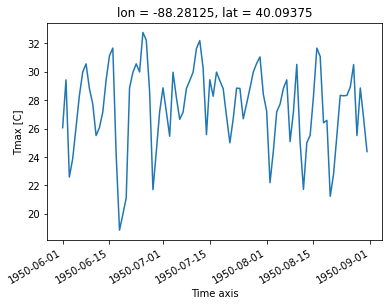

In [11]:
# Simple example plot: Tmax timeseries during JJA 1950 for grid point close to Champaign
# This is the first instance in which we actually load the data
fig, ax = plt.subplots()

ds.sel(lat=40.115, lon=-88.272778, method='nearest')['Tmax'].plot(ax=ax)

plt.show()

In [8]:
# Simple example calculation: JJA average over entire domain
# ds_avg is still a 'lazy' dask array - nothing has been loaded or computed yet
ds_avg = ds.mean("time")

In [9]:
# Here is where we actually compute
ds_avg = ds_avg.compute()

/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


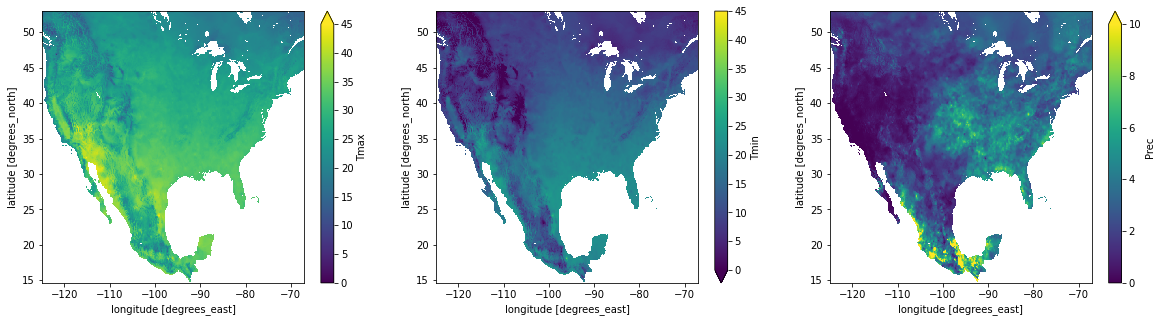

In [10]:
# Plot
fig, ax = plt.subplots(1,3, figsize=(20,5))

ds_avg['Tmax'].plot(ax=ax[0], vmin=0, vmax=45)
ds_avg['Tmin'].plot(ax=ax[1], vmin=0, vmax=45)
ds_avg['Prec'].plot(ax=ax[2], vmin=0, vmax=10)

plt.show()

In [16]:
# Simple example calculation: JJA 90th percentile
ds_q90 = ds.chunk({'time':-1}).quantile(q=0.9, dim="time").compute()

/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/davidlafferty/opt/anaconda3/envs/cropswitching/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


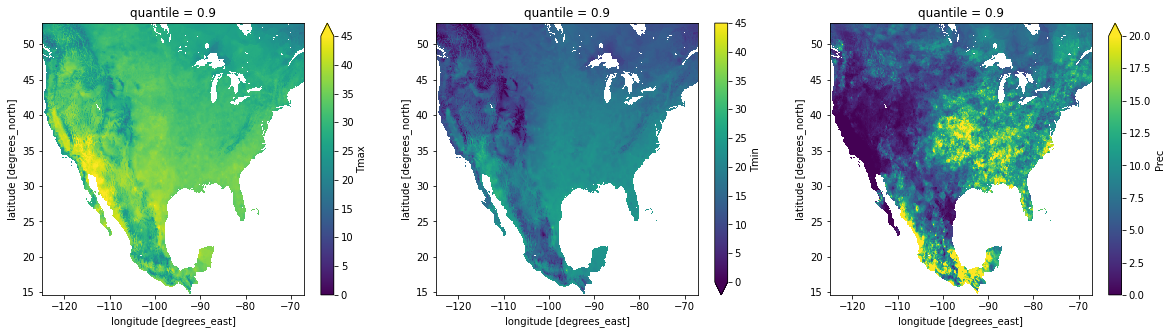

In [20]:
# Plot
fig, ax = plt.subplots(1,3, figsize=(20,5))

ds_q90['Tmax'].plot(ax=ax[0], vmin=0, vmax=45)
ds_q90['Tmin'].plot(ax=ax[1], vmin=0, vmax=45)
ds_q90['Prec'].plot(ax=ax[2], vmin=0, vmax=20)

plt.show()